# <a name="0">Machine Learning Accelerator - Natural Language Processing - Lecture 2</a>

## Neural Networks with PyTorch

In this notebook, we will build, train and validate a Neural Network using PyTorch.
1. <a href="#1">Implementing a neural network with PyTorch</a>
2. <a href="#2">Loss Functions</a>
3. <a href="#3">Training</a>
4. <a href="#4">Example - Binary Classification</a>
5. <a href="#5">Natural Language Processing Context</a>

In [1]:
# Upgrade dependencies
!pip install -q -r ../../requirements.txt

In [2]:
import time
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from torch import nn
from torch.nn import BCELoss
from sklearn.datasets import make_circles
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

sns.set()

%matplotlib inline

## 1. <a name="1">Architecting a neural network with PyTorch</a>
(<a href="#0">Go to top</a>)

Let's implement a simple neural network using the sequencial model in PyTorch (adding layers in sequence). This is a feed-forward NN. We will have two hidden layers. Since the data seems easily seperable, we can have a small network (2 hidden layers) with 10 units at each layer. We will use the commonly employed ReLU function as activation.

In [3]:
net = nn.Sequential(
    # Input size of 1 is expected. Linear layer-1 with 10 units
    nn.Linear(in_features=2, out_features=10),
    # Relu activation is applied
    nn.ReLU(),
    # Linear layer-2 with 10 units
    nn.Linear(10, 10),
    # Relu activation is applied
    nn.ReLU(),
    # Output layer with single unit
    nn.Linear(10, 1),
    # Add Sigmoid at the end to turn output to probabilities
    nn.Sigmoid(),
)

print(net)

Sequential(
  (0): Linear(in_features=2, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=10, bias=True)
  (3): ReLU()
  (4): Linear(in_features=10, out_features=1, bias=True)
  (5): Sigmoid()
)


We can initialize the weights of the network with 'initialize()' function. We prefer to use the following:

In [4]:
def xavier_init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)

net.apply(xavier_init_weights)

Sequential(
  (0): Linear(in_features=2, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=10, bias=True)
  (3): ReLU()
  (4): Linear(in_features=10, out_features=1, bias=True)
  (5): Sigmoid()
)

## 2. <a name="2">Loss Functions</a>
(<a href="#0">Go to top</a>)

We can select [loss functions](https://d2l.ai/chapter_linear-networks/linear-regression.html#loss-function) according to our problem. A full list of supported `Loss` functions in PyTorch are available [here](https://pytorch.org/docs/stable/nn.html#loss-functions). 

Let's go over some popular loss functions and see how to call a built-in loss function:


__Binary Cross-entropy Loss:__ A common used loss function for binary classification. 

```python
loss = nn.BCELoss()
```

__Categorical Cross-entropy Loss:__ A common used loss function for multi-class classification. 

```python
loss = nn.CrossEntropyLoss()
```

__MSE Loss:__ One of the most common loss functions for regression problems. 

```python
loss = nn.MSELoss()
```

__L1 Loss:__ This is similar to L2 loss. It measures the abolsute difference between target values (y) and predictions (p).
$$
\mathrm{L1 Loss} = \frac{1}{2} \sum_{examples}|y - p|
$$
In pytorch, we can use it with `L1Loss`:
```python
loss = nn.L1Loss()
```

## 3. <a name="3">Training</a>
(<a href="#0">Go to top</a>)

`torch.optim` module provides necessary optimization algorithms for neural networks. We can use the following `Optimizers` to train a network using [Stochastic Gradient Descent (SGD)](https://d2l.ai/chapter_optimization/sgd.html) method and learning rate of 0.001.

```python
from torch import optim
optimizer = optim.SGD(net.parameters(), lr=0.001)
```

## 4. <a name="4">Example - Binary Classification</a>
(<a href="#0">Go to top</a>)

Let's train a neural network on a random dataset. We have two classes and will learn to classify them.

In [5]:
X, y = make_circles(
    n_samples=750, shuffle=True, random_state=42, noise=0.05, factor=0.3
)

Let's plot the dataset

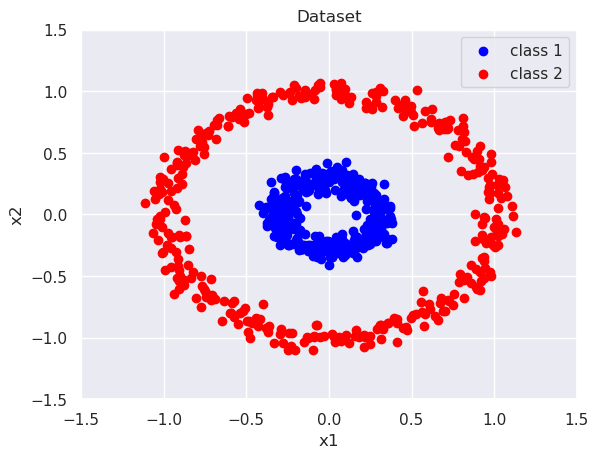

In [6]:
def plot_dataset(X, y, title):

    # Plot both classes: Class1->Blue, Class2->Red
    plt.scatter(X[y == 1, 0], X[y == 1, 1], c="blue", label="class 1")
    plt.scatter(X[y == 0, 0], X[y == 0, 1], c="red", label="class 2")
    plt.legend(loc="upper right")
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.xlim(-1.5, 1.5)
    plt.ylim(-1.5, 1.5)
    plt.title(title)
    plt.show()


plot_dataset(X, y, title="Dataset")

We will train the net defined in <a href="#1">Section 1</a>.

In [7]:
net

Sequential(
  (0): Linear(in_features=2, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=10, bias=True)
  (3): ReLU()
  (4): Linear(in_features=10, out_features=1, bias=True)
  (5): Sigmoid()
)

Let's define the training parameters

In [8]:
# How many samples to use for each weight update
batch_size = 4
# Total number of iterations over the full data set
epochs = 50
# Learning rate
lr = 0.01
# Run in GPU if available else in CPE
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define the loss. As we used sigmoid in the last layer, we use `nn.BCELoss`.
# Otherwise we could have made use of `nn.BCEWithLogitsLoss`.
# reduction='sum' sums up the losses for a given batch
loss = BCELoss(reduction="sum")

# Define the optimizer, SGD with learning rate
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

In [9]:
# Split the dataset into two parts: 80%-10%-10% split
X_train, X_val, X_test = X[: int(len(X) * 0.8), :], X[int(len(X) * 0.8) : int(len(X) * 0.9), :], X[int(len(X) * 0.9) :, :] 
y_train, y_val, y_test = y[: int(len(X) * 0.8)], y[int(len(X) * 0.8) : int(len(X) * 0.9)], y[int(len(X) * 0.9) :]

# Use PyTorch DataLoaders to load the data in batches
train_dataset = torch.utils.data.TensorDataset(
    torch.tensor(X_train, dtype=torch.float32),
    torch.tensor(y_train, dtype=torch.float32),
)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)

# Move validation dataset on CPU/GPU device
X_val = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val = torch.tensor(y_val, dtype=torch.float32).to(device)

Let's start the training process. We will have training and validation sets and print our losses at each step.

In [10]:
train_losses = []
val_losses = []

net.to(device)

for epoch in range(epochs):
    start = time.time()
    training_loss = 0

    # Build a training loop, to train the network
    for idx, (data, target) in enumerate(train_loader):
        # zero the parameter gradients
        optimizer.zero_grad()

        data = data.to(device)
        target = target.to(device).view(-1, 1)

        output = net(data)
        L = loss(output, target)
        training_loss += L.item()
        L.backward()
        optimizer.step()

    # Get validation predictions
    val_predictions = net(X_val)
    # Calculate the validation loss
    val_loss = loss(val_predictions, y_val.view(-1, 1)).item()

    # Take the average losses
    training_loss = training_loss / len(y_train)
    val_loss = val_loss / len(y_val)

    train_losses.append(training_loss)
    val_losses.append(val_loss)

    end = time.time()
    print(
        f"Epoch {epoch}. Train_loss {training_loss:.4f}, Validation_loss {val_loss:.4f}. Seconds {end-start:.3f}"
    )

Epoch 0. Train_loss 0.6765, Validation_loss 0.6727. Seconds 0.798
Epoch 1. Train_loss 0.6378, Validation_loss 0.6331. Seconds 0.126
Epoch 2. Train_loss 0.5689, Validation_loss 0.5479. Seconds 0.135
Epoch 3. Train_loss 0.4385, Validation_loss 0.3843. Seconds 0.130
Epoch 4. Train_loss 0.2763, Validation_loss 0.2290. Seconds 0.132
Epoch 5. Train_loss 0.1642, Validation_loss 0.1424. Seconds 0.127
Epoch 6. Train_loss 0.1077, Validation_loss 0.0984. Seconds 0.128
Epoch 7. Train_loss 0.0777, Validation_loss 0.0739. Seconds 0.126
Epoch 8. Train_loss 0.0600, Validation_loss 0.0586. Seconds 0.130
Epoch 9. Train_loss 0.0484, Validation_loss 0.0482. Seconds 0.134
Epoch 10. Train_loss 0.0404, Validation_loss 0.0407. Seconds 0.137
Epoch 11. Train_loss 0.0345, Validation_loss 0.0351. Seconds 0.134
Epoch 12. Train_loss 0.0300, Validation_loss 0.0308. Seconds 0.138
Epoch 13. Train_loss 0.0266, Validation_loss 0.0274. Seconds 0.136
Epoch 14. Train_loss 0.0238, Validation_loss 0.0247. Seconds 0.132
Epoch

Let's see the training and validation loss plots below. Losses go down as the training process continues as expected.

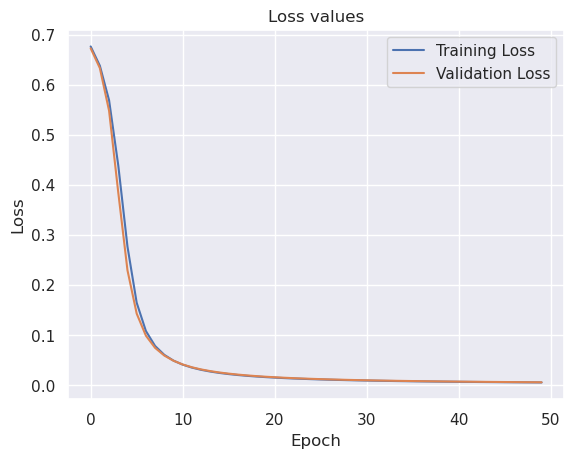

In [11]:
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Loss values")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [12]:
# Get validation predictions
val_predictions = net(X_val)
val_predictions = np.squeeze(np.rint(val_predictions.detach().cpu().numpy()))
print(val_predictions[:10])

[1. 1. 1. 1. 1. 1. 0. 0. 0. 1.]


In [13]:
# Use the fitted pipeline to make predictions on the validation dataset
y_val = y_val.detach().cpu().numpy()
print(confusion_matrix(y_val, val_predictions))
print(classification_report(y_val, val_predictions))
print("Accuracy (validation):", accuracy_score(y_val, val_predictions))

[[34  0]
 [ 0 41]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        34
         1.0       1.00      1.00      1.00        41

    accuracy                           1.00        75
   macro avg       1.00      1.00      1.00        75
weighted avg       1.00      1.00      1.00        75

Accuracy (validation): 1.0


Our FFNN succeeds at classifying the circles data set completely correctly!

Let's plot the decision boundary that it has learned to separate the two classes.

In [14]:
# Create a grid of points on the XY plane
grid = torch.tensor(
    [[x, y] for y in torch.linspace(-1.5, 1.5, 64) for x in torch.linspace(-1.5, 1.5, 64)],
    device=device,
)
# Predict with the net on the grid
grid_predict = net(grid)
# Transform the prediction probs into classes
grid_predict = np.squeeze(np.rint(grid_predict.detach().cpu().numpy()))

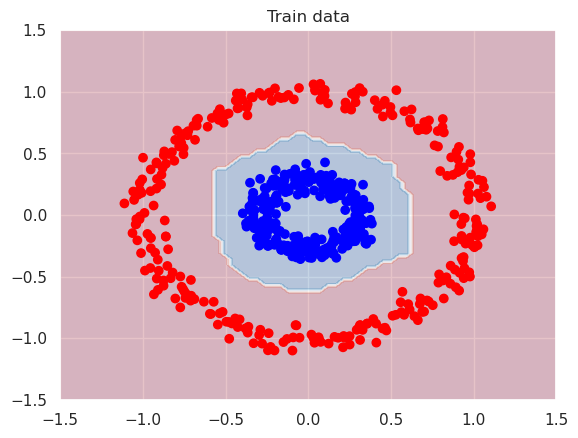

In [15]:
# Plot the countours and the original training data
plt.contourf(
    grid[:, 0].reshape(64, 64).tolist(),
    grid[:, 1].reshape(64, 64).tolist(),
    grid_predict.reshape(64, 64).tolist(),
    alpha=0.25, cmap="RdBu"
)
colormap = {1: "blue", 0: "red"}
plt.scatter(X_train[:, 0], X_train[:, 1], c=[colormap[y] for y in y_train])
plt.title("Train data");

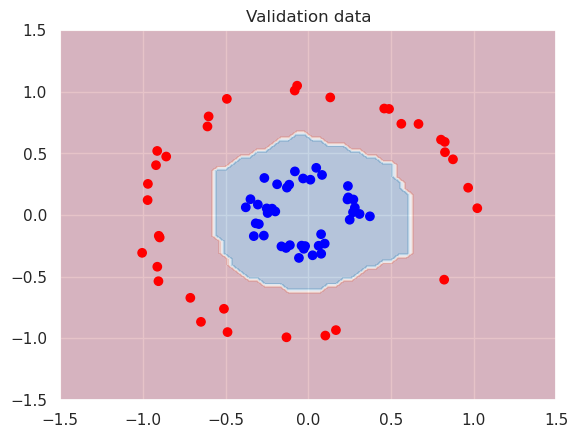

In [16]:
# Plot the countours and the validation data
plt.contourf(
    grid[:, 0].reshape(64, 64).tolist(),
    grid[:, 1].reshape(64, 64).tolist(),
    grid_predict.reshape(64, 64).tolist(),
    alpha=0.25, cmap="RdBu"
)
colormap = {1: "blue", 0: "red"}
plt.scatter(X_val[:, 0].cpu(), X_val[:, 1].cpu(), c=[colormap[y] for y in y_val])
plt.title("Validation data");

In [17]:
# Move test dataset on CPU/GPU device
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)


In [18]:
# Get test predictions
test_predictions = net(X_test)
test_predictions = np.squeeze(np.rint(test_predictions.detach().cpu().numpy()))
print(test_predictions[:10])

[1. 1. 1. 0. 1. 1. 0. 1. 1. 0.]


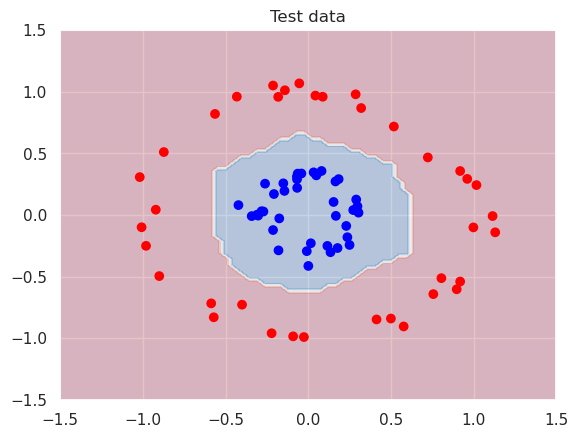

In [19]:
# Plot the countours and the test data and mark the prediction as red & blue
plt.contourf(
    grid[:, 0].reshape(64, 64).tolist(),
    grid[:, 1].reshape(64, 64).tolist(),
    grid_predict.reshape(64, 64).tolist(),
    alpha=0.25, cmap="RdBu"
)
colormap = {1: "blue", 0: "red"}
plt.scatter(X_test[:, 0].cpu(), X_test[:, 1].cpu(), c=[colormap[y] for y in test_predictions])
plt.title("Test data");

## 5. <a name="5">Natural Language Processing Context</a>
(<a href="#0">Go to top</a>)

If we want to use the same type of architecture for text classification, we need to apply some feature extraction methods first. For example: We can get TF-IDF vectors of text fields. After that, we can use neural networks on those features. 

We will also look at __more advanced neural network architrectures__ such as __Recurrent Neural Networks (RNNs)__, __Long Short-Term Memory networks (LSTMs)__ and __Transformers__. 